## Analyze e2e latencies for the single_client_e2e experiment

In [ ]:
import numpy as np
import glob

def get_append_metrics(path):
    file_pattern = path + "append_metrics*.csv"

    total_throughput = 0
    latency_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                gsn, latency, throughput = int(parts[0]), float(parts[1]), float(parts[2])
                latency_values.append(latency)
            
            total_throughput += throughput

    latency_array = np.array(latency_values)

    mean_latency = np.mean(latency_array)
    p50_latency = np.percentile(latency_array, 50)
    p99_latency = np.percentile(latency_array, 99)

    print("results for computation time " + path.split("_")[-1].split("/")[0] + " us")
    print("statistic/metric, latency (us)")
    print(f"mean, {mean_latency:.2f}")
    print(f"p50, {p50_latency:.2f}")
    print(f"p99, {p99_latency:.2f}")
    print(f"total throughput, {total_throughput:.2f}")

    return int(path.split("_")[-1].split("/")[0]), mean_latency, total_throughput 

def get_e2e_metrics(path):
    file_pattern = path + "e2e_metrics*.csv"

    delivery_latency_values = []
    e2e_latency_values = []
    queuing_delay_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                delivery, e2e, queuing_delay = float(parts[1]), float(parts[2]), float(parts[3])
                delivery_latency_values.append(delivery)
                e2e_latency_values.append(e2e)
                queuing_delay_values.append(queuing_delay)

    
    delivery_latency_array = np.array(delivery_latency_values)
    e2e_latency_array = np.array(e2e_latency_values)
    queuing_delay_array = np.array([x for x in queuing_delay_values if x > 0])

    print("statistic/metric, delivery latency (us), e2e latency (us), queuing delay (us)")
    print(f"mean, {np.mean(delivery_latency_array):.2f}, {np.mean(e2e_latency_array):.2f}, {np.mean(queuing_delay_array):.2f}")
    print(f"std, {np.std(delivery_latency_array):.2f}, {np.std(e2e_latency_array):.2f}, {np.std(queuing_delay_array):.2f}")
    print(f"p50, {np.percentile(delivery_latency_array, 50):.2f}, {np.percentile(e2e_latency_array, 50):.2f}, {np.percentile(queuing_delay_array, 50):.2f}")
    print(f"p99, {np.percentile(delivery_latency_array, 99):.2f}, {np.percentile(e2e_latency_array, 99):.2f}, {np.percentile(queuing_delay_array, 99):.2f}")

    return int(path.split("_")[-1].split("/")[0]), np.mean(delivery_latency_array), np.mean(e2e_latency_array), np.mean(queuing_delay_array)


def get_splits(path):
    file_pattern = path + "e2e_metrics*.csv"

    delivery_latency_values = []
    e2e_latency_values = []
    queuing_delay_values = []

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(',')
                delivery, e2e, queuing_delay = float(parts[1]), float(parts[2]), float(parts[3])
                delivery_latency_values.append(delivery)
                e2e_latency_values.append(e2e)
                queuing_delay_values.append(queuing_delay)

    
    delivery_latency_array = np.array(delivery_latency_values)
    e2e_latency_array = np.array(e2e_latency_values)
    queuing_delay_array = np.array([x for x in queuing_delay_values if x > 0])

    min_size = min(len(delivery_latency_array), len(e2e_latency_array), len(queuing_delay_array))

    delivery_latency_array = delivery_latency_array[:min_size]
    e2e_latency_array = e2e_latency_array[:min_size]
    queuing_delay_array = queuing_delay_array[:min_size]

    compute = e2e_latency_array - delivery_latency_array - queuing_delay_array

    print("results for computation time " + path.split("_")[-1].split("/")[0] + " us")
    print("statistic/metric, delivery latency (us), computation time (us), queuing delay (us)")
    print(f"mean, {np.mean(delivery_latency_array):.2f}, {np.mean(compute):.2f}, {np.mean(queuing_delay_array):.2f}")
    print(f"p50, {np.percentile(delivery_latency_array, 50):.2f}, {np.percentile(compute, 50):.2f}, {np.percentile(queuing_delay_array, 50):.2f}")
    print(f"p99, {np.percentile(delivery_latency_array, 99):.2f}, {np.percentile(compute, 99):.2f}, {np.percentile(queuing_delay_array, 99):.2f}")

In [ ]:
path = "../results/*"

for dir in glob.glob(path + "*/"):
    get_append_metrics(dir)
    get_e2e_metrics(dir)


In [ ]:
path = "../results/*"
for dir in glob.glob(path + "*/"):
    get_splits(dir)

In [ ]:
import re
import pandas as pd

# Input data
data = """
PLEASE PASTE ABOVE DATA HERE
"""

# Split data into lines
lines = data.splitlines()

# Parsing logic
results = []
current_time = None
append_latency = None

for i, line in enumerate(lines):
    line = line.strip()
    # Detect computation time
    if line.startswith("results for computation time"):
        match = re.search(r"computation time (\d+) us", line)
        if match:
            current_time = int(match.group(1))
    # Extract append latency (first "latency (us)" mean value)
    elif "statistic/metric, latency (us)" in line:
        append_line = lines[i + 1]  # Look at the next line
        append_match = re.match(r"mean,\s*([\d.]+)", append_line)
        if append_match:
            append_latency = float(append_match.group(1))
    # Extract other latencies (mean values)
    elif line.startswith("mean,") and current_time is not None:
        parts = line.split(",")
        if len(parts) == 4:  # Ensure correct format
            delivery_latency, e2e_latency, queueing_delay = map(float, parts[1:])
            results.append({
                "computation_time": current_time,
                "append_latency": append_latency,
                "delivery_latency": delivery_latency,
                "e2e_latency": e2e_latency,
                "queueing_delay": queueing_delay,
            })

# Create a DataFrame
df = pd.DataFrame(results)

df.to_csv("output.csv", index=False)

# Print the CSV content
print(df.to_csv(index=False))

## Analyze order server log from the reconfiguration experiment

In [ ]:
import re
import matplotlib.pyplot as plt
from datetime import datetime

# File path
log_file = "../results/reconfig_800/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"

# Data storage
timestamps = []
tput_values = []
shard_added = [] # when did the shards send their first cut to the OL
first_cut_committed = [] # when did the first cut get committed
shard_leave_request = [] 
shard_finalized = []
replica_2_added = []
replica_3_added = []
replica_2_committed = []
replica_3_committed = []

# Parse the log file
with open(log_file, "r") as f:
    for line in f:
        # Extract real-time throughput
        tput_match = re.search(tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(datetime.strptime(timestamp_match.group(1), "%H:%M:%S.%f"))
        
        # Extract events for annotation
        if replica_2_added == [] and "Replica 2 added" in line:
            replica_2_added.append(timestamp_match.group(1))

        if replica_3_added == [] and "Replica 3 added" in line:
            replica_3_added.append(timestamp_match.group(1))

        if replica_2_committed == [] and "cut:<key:2" in line:
            replica_2_committed.append(timestamp_match.group(1))
        
        if replica_3_committed == [] and "cut:<key:3" in line:
            replica_3_committed.append(timestamp_match.group(1))
        
        if shard_finalized == [] and "finalizeShards:<shardIDs:1 >" in line:
            shard_finalized.append(timestamp_match.group(1))

        if shard_leave_request == [] and "Shard 1 to be finalized" in line:
            shard_leave_request.append(timestamp_match.group(1))

shard_added.append(max(replica_2_added[0], replica_3_added[0]))
first_cut_committed.append(max(replica_2_committed[0], replica_3_committed[0]))

# Convert timestamps to seconds since the start
start_time = timestamps[0]
time_in_seconds = [(ts - start_time).total_seconds() for ts in timestamps]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_in_seconds, tput_values, label="Throughput (ops/sec)", color="blue")
plt.xlabel("Time (seconds)")
plt.ylabel("Throughput (ops/sec)")
plt.title("Real-time Throughput vs Time")
plt.grid()

# Event times
shard_join_request = (datetime.strptime(shard_added[0], "%H:%M:%S.%f") - start_time).total_seconds()
first_cut_committed_time = (datetime.strptime(first_cut_committed[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_leave_request_time = (datetime.strptime(shard_leave_request[0], "%H:%M:%S.%f") - start_time).total_seconds()
shard_finalized_time = (datetime.strptime(shard_finalized[0], "%H:%M:%S.%f") - start_time).total_seconds()

# Add vertical lines for events
plt.axvline(shard_join_request, color="red", linestyle="--", alpha=0.7, label="shard requests to join")
plt.axvline(first_cut_committed_time, color="purple", linestyle="--", alpha=0.7, label="first cut committed from new shard")
plt.axvline(shard_leave_request_time, color="orange", linestyle="--", alpha=0.7, label="shard requests to leave")
plt.axvline(shard_finalized_time, color="black", linestyle="--", alpha=0.7, label="shard finalized, last committed cut")

# Zoom in to the relevant range (adjust as needed)
# plt.xlim(22.5, 24)
# plt.xlim(10, 65)
plt.xlim(52, 55)

# Add legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()

# Save the plot
plt.savefig("adding_reconfig_throughput_annotated.png", dpi=600)

plt.show()


In [ ]:
## Analyze latencies for lagfix experiment
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import bisect

timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"


def parse_timestamp(time):
    return datetime.strptime(time, "%H:%M:%S.%f")

def analyze_reconfig(path):
    client_path = path + "client_node13.log"
    e2e_path = path + "e2e_metrics.csv"

    join_time = None
    leave_time = None
    # Determine join and leave GSN
    with open(client_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if "View id: 2" in line and join_time is None:
                join_time = re.search(timestamp_pattern, line).group(1)
            if "View id: 3" in line and leave_time is None:
                leave_time = re.search(timestamp_pattern, line).group(1)

    # Parse e2e metrics
    timestamps = []
    latencies = []
    gsns = []
    with open(e2e_path, 'r') as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split(',')
            gsn = int(parts[0])
            e2e_latency = int(parts[2])
            timestamp = parts[4]
            gsns.append(gsn)
            latencies.append(e2e_latency)
            timestamps.append(datetime.strptime(timestamp, "%H:%M:%S.%f"))

    # Prepare data for the plot
    df = pd.DataFrame({
        'time': timestamps,
        'latency': latencies
    })
    df = df.sort_values(by='time')

    # Calculate moving average
    window_size = 500  # Set window size for moving average
    df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

    # Calculate relative time
    min_time = df['time'].min()
    df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

    # Plot moving average and markers
    plt.figure(figsize=(10, 6))
    plt.plot(df['relative_time_ms'], df['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)

    # Plot join and leave markers
    join_time_relative = (parse_timestamp(join_time) - min_time).total_seconds() * 1000
    leave_time_relative = (parse_timestamp(leave_time) - min_time).total_seconds() * 1000
    plt.axvline(x=join_time_relative, color='green', linestyle=':', label='Shard Added')
    plt.axvline(x=leave_time_relative, color='red', linestyle=':', label='Shard Removed')

    # Calculate the average latency
    average_latency = df['latency'].mean()

    # Plot the average latency as a horizontal line
    plt.axhline(y=average_latency, color='orange', linestyle='--', label=f'Average Latency ({average_latency:.2f} µs)')


    # Customize plot
    plt.xlabel('Time (ms)')
    plt.ylabel('Latency (us)')
    plt.title('Latency Over Time with Moving Average')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0, ymax=9000)
    # plt.xlim(xmin=15000, xmax=17000)
    # plt.xlim(xmin=45000, xmax=46000)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plt.savefig("output.png", dpi=600)
    print("Plot saved as output.png")

path = "../results/reconfig_800_scalog/"
analyze_reconfig(path)

## Analyze script for lagfix plots for e2e and append latency

In [4]:
import numpy as np
import glob

# analyze logs to get latency metrics for lagfix experiment
def get_latency_metrics_for_lagfix(path):
    e2e_file_pattern = path + "e2e_metrics.csv"
    append_file_pattern = path + "append_latency_timestamp.csv"
    append_latency_values = {}
    e2e_latency_values = {}
    gsns = []

    for file in glob.glob(e2e_file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, e2e_latency, delivery_timestamp = int(parts[0]), int(parts[2]), parts[4]
                e2e_latency_values[gsn] = [e2e_latency, delivery_timestamp]


    for file in glob.glob(append_file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, timestamp, latency = int(parts[0]), parts[1], int(parts[2])
                append_latency_values[gsn] = [latency, timestamp]
    
    client_file = path + "client_node7.log"
    with open(client_file, 'r') as f:
        log_data = f.read()
        for line in log_data.splitlines():
            if "gsn: " in line:
                try:
                    gsn = int(line.split()[-1])  
                    gsns.append(gsn)
                except ValueError:
                    print(f"Skipping invalid GSN: {line.split()[-1]}")

    gsns.sort()
    return append_latency_values, e2e_latency_values, gsns


path = "../results/lagfix/"
append_latency_values, e2e_latency_values, gsns = get_latency_metrics_for_lagfix(path)

append_latency_array = np.array([append_latency_values[gsn][0] for gsn in append_latency_values])
mean_latency = np.mean(append_latency_array)
p99_latency = np.percentile(append_latency_array, 99)

e2e_latency_array = np.array([e2e_latency_values[gsn][0] for gsn in e2e_latency_values])
mean_e2e_latency = np.mean(e2e_latency_array)
p99_e2e_latency = np.percentile(e2e_latency_array, 99)

print(f"mean append latency: {mean_latency:.2f} us")
print(f"p99 latency: {p99_latency:.2f} us")
print(f"mean e2e latency: {mean_e2e_latency:.2f} us")
print(f"p99 e2e latency: {p99_e2e_latency:.2f} us")

mean append latency: 2829.39 us
p99 latency: 4273.00 us
mean e2e latency: 4253.45 us
p99 e2e latency: 5965.00 us


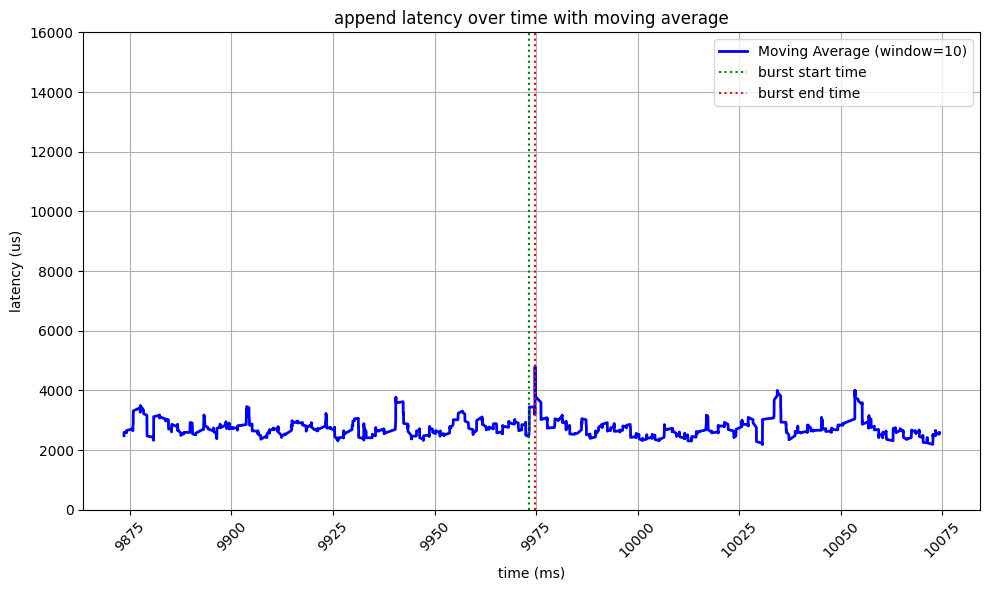

In [5]:
## Plot append latency over time with moving average


import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

append_latency_times = []
append_latencies = []
for gsn, (latency, timestamp) in append_latency_values.items():
    append_latency_times.append(datetime.strptime(timestamp, "%H:%M:%S.%f"))
    append_latencies.append(latency)

df = pd.DataFrame({
    'time': append_latency_times,
    'latency': append_latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 10  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = datetime.strptime(append_latency_values[gsns[0]][1], "%H:%M:%S.%f") - timedelta(milliseconds=100)  
end_time = datetime.strptime(append_latency_values[gsns[-1]][1], "%H:%M:%S.%f") + timedelta(milliseconds=100)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)

start_time_relative = (datetime.strptime(append_latency_values[gsns[0]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
end_time_relative = (datetime.strptime(append_latency_values[gsns[-1]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')
plt.axvline(x=end_time_relative, color='red', linestyle=':', label=f'burst end time')

plt.xlabel('time (ms)')
plt.ylabel('latency (us)')
plt.title('append latency over time with moving average')
plt.xticks(rotation=45)
plt.ylim(ymin=0, ymax=16000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("append_without.png", dpi=600)

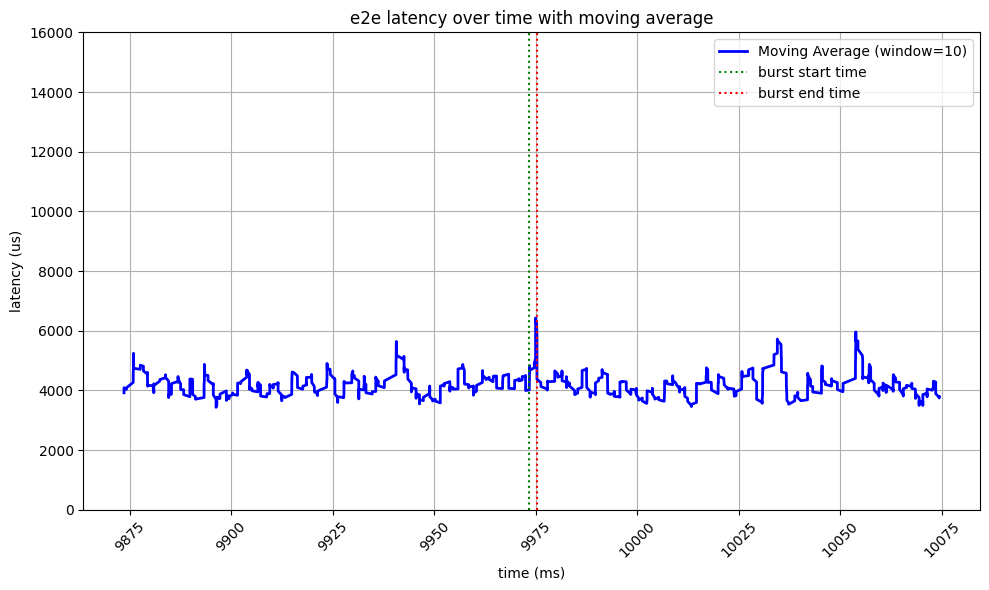

In [6]:
## Plot e2e latency over time with moving average


import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
e2e_latency_times = []
e2e_latencies = []
for gsn, (latency, timestamp) in e2e_latency_values.items():
    e2e_latency_times.append(datetime.strptime(timestamp, "%H:%M:%S.%f"))
    e2e_latencies.append(latency)

df = pd.DataFrame({
    'time': e2e_latency_times,
    'latency': e2e_latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 10  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = datetime.strptime(e2e_latency_values[gsns[0]][1], "%H:%M:%S.%f") - timedelta(milliseconds=100)  
end_time = datetime.strptime(e2e_latency_values[gsns[-1]][1], "%H:%M:%S.%f") + timedelta(milliseconds=100)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)


start_time_relative = (datetime.strptime(e2e_latency_values[gsns[0]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
end_time_relative = (datetime.strptime(e2e_latency_values[gsns[-1]][1], "%H:%M:%S.%f") - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')
plt.axvline(x=end_time_relative, color='red', linestyle=':', label=f'burst end time')


plt.xlabel('time (ms)')
plt.ylabel('latency (us)')
plt.title('e2e latency over time with moving average')
plt.xticks(rotation=45)
plt.ylim(ymin=0, ymax=16000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("e2e_without.png", dpi=600)

### Analyze script for quota change experiment for e2e and append latency

In [25]:
## Find burst start lcn and wn

import re

def extract_burst_cut(log_file_path):    
    pattern = r"burst local cut number (\d+)"
    with open(log_file_path, "r") as file:
        log_content = file.read()
    matches = re.findall(pattern, log_content)

    if matches:
        return matches[0]
    else:
        return None

# CONFIGURE PATH HERE
logfile = "../results/qc/data-0-0.log"
burst_cut_num = extract_burst_cut(logfile)
print(f"Burst cut number: {burst_cut_num}")

Burst cut number: 35042


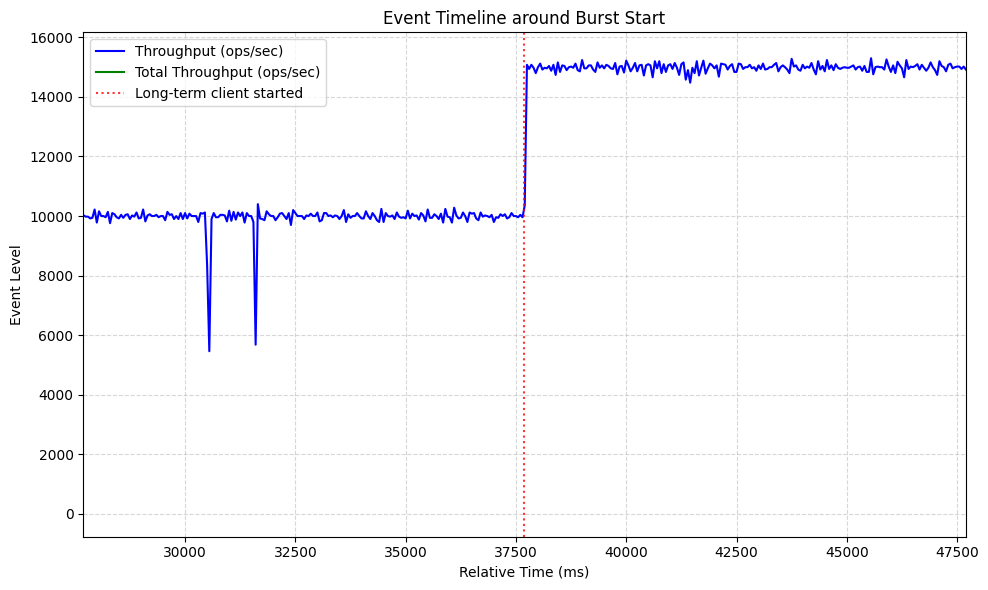

In [26]:
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Helper function to parse timestamps
def parse_timestamp(ts):
    return datetime.strptime(ts, "%H:%M:%S.%f")

# File path
log_file = "../results/qc/order-0.log"

# Regex patterns
tput_pattern = r"\[real-time tput\]: (\d+) ops/sec"
total_tput_pattern = r"\[real-time total tput\]: (\d+) ops/sec"
timestamp_pattern = r"(\d{2}:\d{2}:\d{2}\.\d{6})"
cut_pattern = rf"{timestamp_pattern} cut:(\d+) cut:(\d+)"
burst_cut_pattern = rf"cut:(\d+) cut:0 localCutNum:{burst_cut_num}"

timestamps = []
tput_values = []
total_tput_timestamps = []
total_tput_values = []
shard_0_cuts = []
shard_1_cuts = []
burst_start = []

with open(log_file, "r") as f:
    for line in f:
        # Extract throughput
        tput_match = re.search(tput_pattern, line)
        total_tput_match = re.search(total_tput_pattern, line)
        timestamp_match = re.search(timestamp_pattern, line)
        
        if tput_match and timestamp_match:
            tput_values.append(int(tput_match.group(1)))
            timestamps.append(parse_timestamp(timestamp_match.group(1)))

        if total_tput_match and timestamp_match:
            total_tput_values.append(int(total_tput_match.group(1)))
            total_tput_timestamps.append(parse_timestamp(timestamp_match.group(1)))

        # Extract shard cuts
        cut_match = re.search(cut_pattern, line)
        if cut_match:
            timestamp, cut_0, cut_1 = cut_match.groups()
            shard_0_cuts.append((parse_timestamp(timestamp), int(cut_0)))
            shard_1_cuts.append((parse_timestamp(timestamp), int(cut_1)))

        # Extract burst start
        burst_cut_pattern_match = re.search(burst_cut_pattern, line)
        if burst_cut_pattern_match and timestamp_match:
            burst_start.append(parse_timestamp(timestamp))


if not burst_start:
    print("No burst start found.")
    exit()
burst_start_time = burst_start[0]

# CONFIGURE ZOOM WINDOW HERE
zoom_window_ms = 10000
zoom_start = burst_start_time - timedelta(milliseconds=zoom_window_ms)
zoom_end = burst_start_time + timedelta(milliseconds=zoom_window_ms)

# Convert to relative times
min_timestamp = min(timestamps + total_tput_timestamps + [c[0] for c in shard_0_cuts + shard_1_cuts])

def to_relative_ms(t):
    return (t - min_timestamp).total_seconds() * 1000

shard_0_times_rel = [to_relative_ms(t) for t, _ in shard_0_cuts if zoom_start <= t <= zoom_end]
shard_1_times_rel = [to_relative_ms(t) for t, _ in shard_1_cuts if zoom_start <= t <= zoom_end]
# quota_times_rel = {to_relative_ms(t): v for t, v in quota_changes.items() if zoom_start <= t <= zoom_end}

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot throughput
ax.plot([to_relative_ms(t) for t in timestamps], tput_values, label="Throughput (ops/sec)", color="blue")

# Plot total throughput
ax.plot([to_relative_ms(t) for t in total_tput_timestamps], total_tput_values, label="Total Throughput (ops/sec)", color="green")

# # Plot Shard 0 cuts
# ax.scatter(shard_0_times_rel, [1 + 0.05 * i for i in range(len(shard_0_times_rel))],
#            label="Shard 0 Cuts", color="blue", marker="o", s=40, alpha=0.6)

# # Plot Shard 1 cuts
# ax.scatter(shard_1_times_rel, [2 + 0.05 * i for i in range(len(shard_1_times_rel))],
#            label="Shard 1 Cuts", color="orange", marker="o", s=40, alpha=0.6)

# Plot quota changes
# for t_rel, (quota_0, quota_1) in quota_times_rel.items():
#     ax.axvline(t_rel, color="green", linestyle="--", alpha=0.8)
#     ax.text(t_rel, 3, f"Q0:{quota_0}\nQ1:{quota_1}", color="green", fontsize=8, rotation=45)

# Highlight burst start
burst_start_rel = to_relative_ms(burst_start_time)
ax.axvline(burst_start_rel, color="red", linestyle=":", alpha=0.8, label="Long-term client started")

# Labels and legend
ax.set_xlabel("Relative Time (ms)")
ax.set_ylabel("Event Level")
ax.set_xlim(to_relative_ms(zoom_start), to_relative_ms(zoom_end))
ax.set_title("Event Timeline around Burst Start")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("qc_tput.png", dpi=600)

In [27]:
## Compute OL load before and after burst
len_shard_0_cuts_before = len([cut for cut in shard_0_cuts if cut[0] < burst_start_time])
len_shard_1_cuts_before = len([cut for cut in shard_1_cuts if cut[0] < burst_start_time])

len_shard_0_cuts_after = len([cut for cut in shard_0_cuts if cut[0] > burst_start_time])
len_shard_1_cuts_after = len([cut for cut in shard_1_cuts if cut[0] > burst_start_time])

print(f"Shard 0 cuts before burst: {len_shard_0_cuts_before}")
print(f"Shard 1 cuts before burst: {len_shard_1_cuts_before}")
print(f"Shard 0 cuts after burst: {len_shard_0_cuts_after}")
print(f"Shard 1 cuts after burst: {len_shard_1_cuts_after}")

Shard 0 cuts before burst: 35041
Shard 1 cuts before burst: 35041
Shard 0 cuts after burst: 33272
Shard 1 cuts after burst: 33272


In [28]:
## analyze latencies for shard 0
import glob
from datetime import datetime, timedelta


def parse_timestamp(timestamp):
    return datetime.strptime(timestamp, "%H:%M:%S.%f")

def get_lat_ts(path):
    file_pattern = path + "e2e_metrics.csv"
    append_pattern = path + "append_metrics.csv"
    e2e_latency_values = {}
    append_latency_values = {}

    for file in glob.glob(append_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, latency, timestamp, tput = int(parts[0]), int(parts[1]), parse_timestamp(parts[2]), float(parts[3])
                append_latency_values[gsn] = [latency, timestamp]

    for file in glob.glob(file_pattern):
        with open(file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header
            for line in lines:
                parts = line.strip().split(',')
                gsn, e2e_latency, delivery_timestamp = int(parts[0]), int(parts[2]), parse_timestamp(parts[4])
                e2e_latency_values[gsn] = [e2e_latency, delivery_timestamp]

    with open(path + "client_node7.log", 'r') as f:
        lines = f.readlines()
        for line in lines:
            if "first append start time" in line:
                burst_start = parse_timestamp(line.split()[-1])
                break

    return append_latency_values, e2e_latency_values, burst_start

# CONFIGURE PATH HERE
path = "../results/qc/"
append_latency_values, e2e_latency_values, burst_start = get_lat_ts(path)
print(f"burst start: {burst_start}")

burst start: 1900-01-01 13:47:21.245170


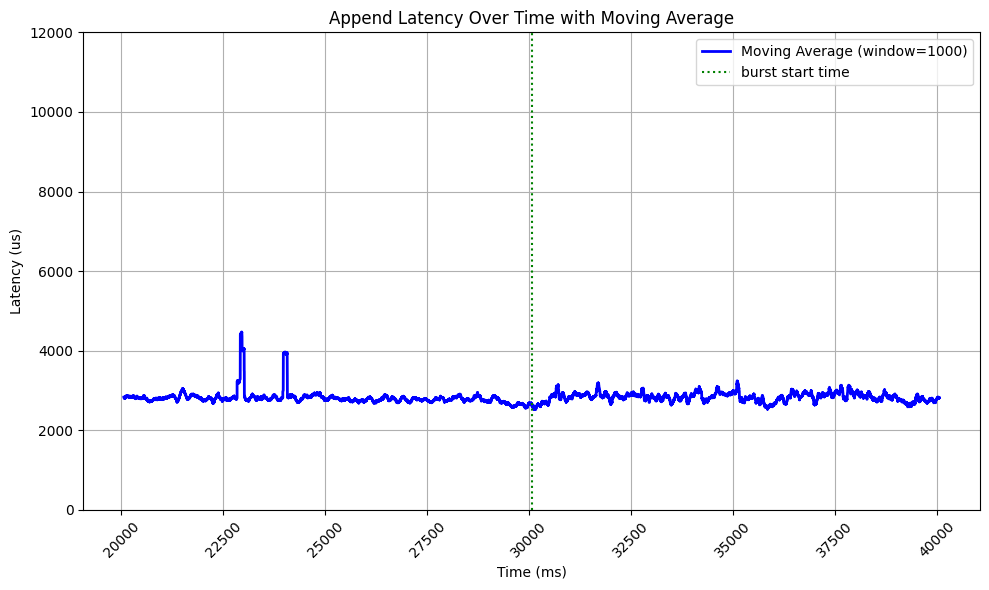

In [29]:
## Append latency plots

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
latency_times = []
latencies = []
for gsn, (latency, timestamp) in append_latency_values.items():
    latency_times.append(timestamp)
    latencies.append(latency)

df = pd.DataFrame({
    'time': latency_times,
    'latency': latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 1000  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = burst_start - timedelta(milliseconds=10000)  
end_time = burst_start + timedelta(milliseconds=10000)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)


start_time_relative = (burst_start - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')


plt.xlabel('Time (ms)')
plt.ylabel('Latency (us)')
plt.title('Append Latency Over Time with Moving Average')
plt.xticks(rotation=45)
plt.ylim(ymin=0, ymax=12000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output.png", dpi=600)

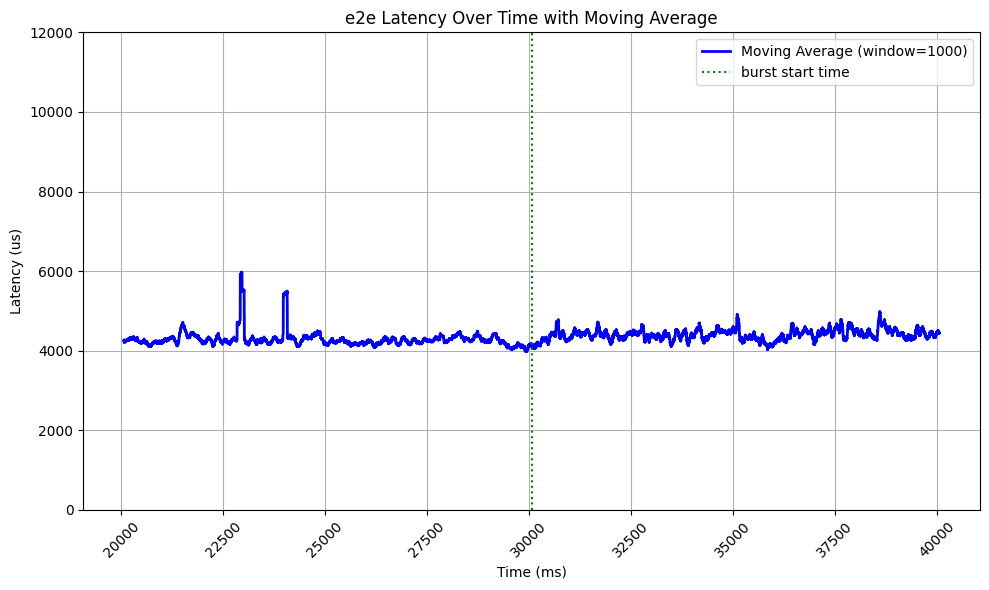

In [30]:
### E2E Latency plots

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
e2e_latency_times = []
e2e_latencies = []
for gsn, (latency, timestamp) in e2e_latency_values.items():
    e2e_latency_times.append(timestamp)
    e2e_latencies.append(latency)

df = pd.DataFrame({
    'time': e2e_latency_times,
    'latency': e2e_latencies
})

df = df.sort_values(by='time')

# CONFIGURE WINDOW SIZE HERE
window_size = 1000  # Set the window size for the moving average
df['moving_avg'] = df['latency'].rolling(window=window_size, min_periods=1).mean()

min_time = df['time'].min()
df['relative_time_ms'] = (df['time'] - min_time).dt.total_seconds() * 1000

# CONFIGURE ZOOM IN PERIOD HERE
start_time = burst_start - timedelta(milliseconds=10000)  
end_time = burst_start + timedelta(milliseconds=10000)  

df_zoomed = df[(df['time'] >= start_time) & (df['time'] <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(df_zoomed['relative_time_ms'], df_zoomed['moving_avg'], label=f'Moving Average (window={window_size})', color='blue', linewidth=2)


start_time_relative = (burst_start - min_time).total_seconds() * 1000
plt.axvline(x=start_time_relative, color='green', linestyle=':', label=f'burst start time')


plt.xlabel('Time (ms)')
plt.ylabel('Latency (us)')
plt.title('e2e Latency Over Time with Moving Average')
plt.xticks(rotation=45)
plt.ylim(ymin=0, ymax=12000)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output.png", dpi=600)